In [ ]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


SEED = 42

## Load data

In [ ]:
# filepath
train_data_path = "/content/caravan.csv"
test_data_path = "/content/caravanTest.csv"

data_train = pd.read_csv(train_data_path)


#print(data_train.head())

## 2.1 Assignment
The purpose of assignment 1 is to give a clear insight to why customers have a caravan insurance
policy and how these customers are different from other customers. Descriptions can be based on
regression equations, decision trees, linguistic descriptions, graphical representations or any other
form. The descriptions and accompanying interpretation must be comprehensible, useful and
actionable for a marketing professional with no prior knowledge of data mining.

Compare some different techniques and/or settings of parameters to see how well they perform
on this problem. For this comparison you may assume some basic knowledge about data mining
with the reader. In Appendix B details are provided how to use scikit-learn For feature selection

## Descriptive statistics for Training data

In [ ]:
# Get basic statistics of training data
print(data_train.describe())

       Customer Subtype  Number of houses  Avg size household      Avg Age  \
count       5822.000000       5822.000000         5822.000000  5822.000000   
mean          24.253349          1.110615            2.678805     2.991240   
std           12.846706          0.405842            0.789835     0.814589   
min            1.000000          1.000000            1.000000     1.000000   
25%           10.000000          1.000000            2.000000     2.000000   
50%           30.000000          1.000000            3.000000     3.000000   
75%           35.000000          1.000000            3.000000     3.000000   
max           41.000000         10.000000            5.000000     6.000000   

       Customer main type  Roman catholic   Protestant  Other religion  \
count         5822.000000     5822.000000  5822.000000     5822.000000   
mean             5.773617        0.696496     4.626932        1.069907   
std              2.856760        1.003234     1.715843        1.017503   
m

In [ ]:
# Check for missing values
row_nan_count = data_train.isna().sum(axis=1)

print(row_nan_count)

0       0
1       0
2       0
3       0
4       0
       ..
5817    0
5818    0
5819    0
5820    0
5821    0
Length: 5822, dtype: int64


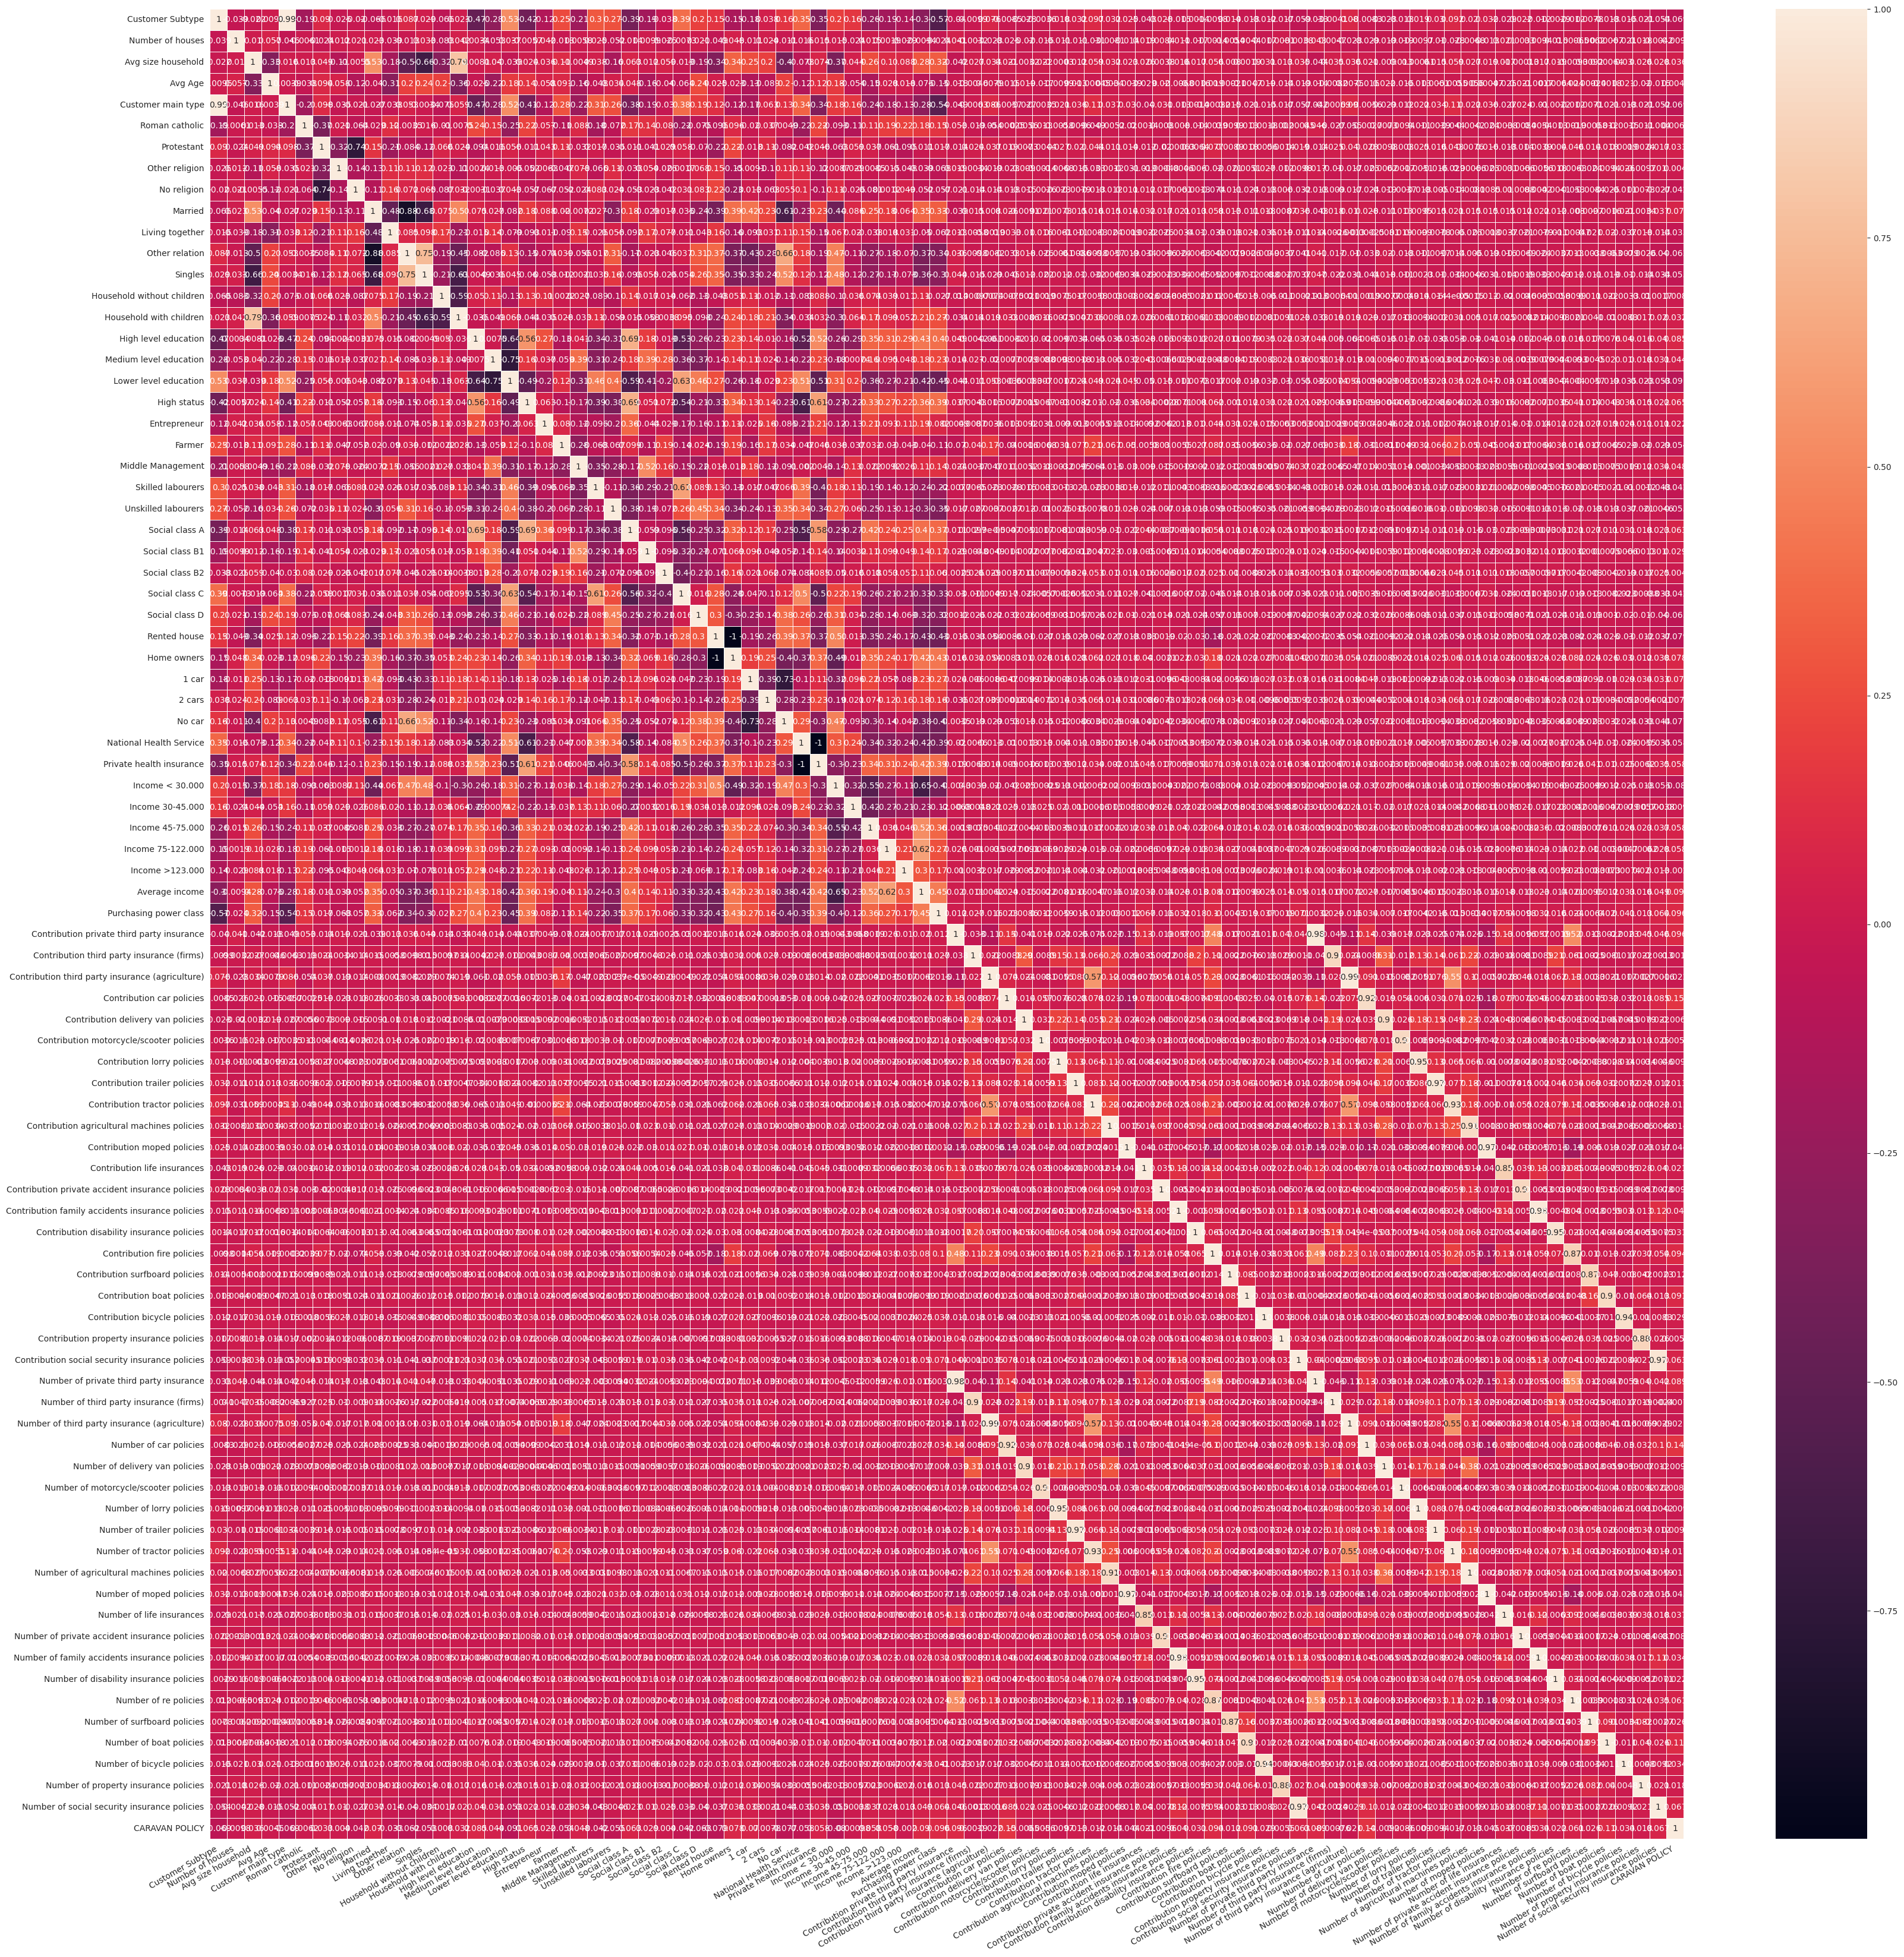

In [ ]:
# Access correlation of features
corrmat = data_train.corr()
#corrmat1 = data_train.iloc[:,1:44].corr()
#corrmat2 = data_train.iloc[:,44:,].corr()
#print(corrmat)

plt.figure(figsize=(40, 40))
sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5)
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

In [ ]:
upper_corr_mat = corrmat.where(
    np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))

# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()

# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()
#print(sorted_mat)

# filter for low and highly correlated feature pairs
low_high_corr = sorted_mat.loc[lambda x : (x < -0.7) | (x > 0.7)]

print(low_high_corr)

# get list of variable names to exclude from data set (one feature per correlated pair)
drop_features = ['Home owners', 'Private health insurance', 'Other relation', 'Lower level education', 'No religion', 'No car', 'Singles',
                 'Household with children', 'Number of life insurances', 'Number of re policies', 'Number of surfboard policies', 'Number of property insurance policies',
                 'Number of third party insurance (firms)','Number of private accident insurance policies', 'Number of delivery van policies', 'Number of boat policies',
                 'Number of motorcycle/scooter policies', 'Number of agricultural machines policies', 'Number of car policies', 'Number of tractor policies',
                 'Number of bicycle policies', 'Number of disability insurance policies','Number of lorry policies', 'Number of trailer policies',
                 'Number of social security insurance policies', 'Number of moped policies', 'Number of family accidents insurance policies',
                 'Number of private third party insurance', 'Number of third party insurance (agriculture)', 'Customer main type']

Home owners                                    Rented house                                       -0.999554
Private health insurance                       National Health Service                            -0.999239
Other relation                                 Married                                            -0.884362
Lower level education                          Medium level education                             -0.747582
No religion                                    Protestant                                         -0.741895
No car                                         1 car                                              -0.734564
Singles                                        Other relation                                      0.745642
Household with children                        Avg size household                                  0.794014
Number of life insurances                      Contribution life insurances                        0.850171
Number of re policies       

<ipython-input-111-f3e6701625e3>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))


In [ ]:
# drop low/high correlated features
data_train1 = data_train.drop(drop_features, axis=1)
data_train1

Customer Subtype  Number of houses  Avg size household  Avg Age  \
0                   33                 1                   3        2   
1                   37                 1                   2        2   
2                   37                 1                   2        2   
3                    9                 1                   3        3   
4                   40                 1                   4        2   
...                ...               ...                 ...      ...   
5817                36                 1                   1        2   
5818                35                 1                   4        4   
5819                33                 1                   3        4   
5820                34                 1                   3        2   
5821                33                 1                   3        3   

      Roman catholic  Protestant  Other religion  Married  Living together  \
0                  0           5               1        7                0   
1                  1           4               1        6                2   
2                  0           4               2        3                2   
3                  2           3               2        5                2   
4                  1           4               1        7                1   
...              ...         ...             ...      ...              ...   
5817               0           6               1        1                2   
5818               1           4               1        6                0   
5819               0           6               0        5                1   
5820               0           7               0        7                2   
5821               0           6               1        7                1   

      Household without children  ...  \
0                              2  ...   
1                              4  ...   
2                              4  ...   
3                              3  ...   
4                              4  ...   
...                          ...  ...   
5817                           3  ...   
5818                           2  ...   
5819                           3  ...   
5820                           4  ...   
5821                           4  ...   

      Contribution private accident insurance policies  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
5817                                                 0   
5818                                                 0   
5819                                                 0   
5820                                                 0   
5821                                                 0   

      Contribution family accidents insurance policies  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
5817                                                 0   
5818                                                 0   
5819                                                 0   
5820                                                 0   
5821                                                 0   

      Contribution disability insurance policies  Contribution fire policies  \
0                                              0                           5   
1                                              0                           2   
2                                              0                 

array([[<Axes: title={'center': 'Customer Subtype'}>,
        <Axes: title={'center': 'Number of houses'}>,
        <Axes: title={'center': 'Avg size household'}>,
        <Axes: title={'center': 'Avg Age'}>,
        <Axes: title={'center': 'Roman catholic'}>,
        <Axes: title={'center': 'Protestant'}>,
        <Axes: title={'center': 'Other religion'}>],
       [<Axes: title={'center': 'Married'}>,
        <Axes: title={'center': 'Living together'}>,
        <Axes: title={'center': 'Household without children'}>,
        <Axes: title={'center': 'High level education'}>,
        <Axes: title={'center': 'Medium level education'}>,
        <Axes: title={'center': 'High status'}>,
        <Axes: title={'center': 'Entrepreneur'}>],
       [<Axes: title={'center': 'Farmer'}>,
        <Axes: title={'center': 'Middle Management'}>,
        <Axes: title={'center': 'Skilled labourers'}>,
        <Axes: title={'center': 'Unskilled labourers'}>,
        <Axes: title={'center': 'Social class A

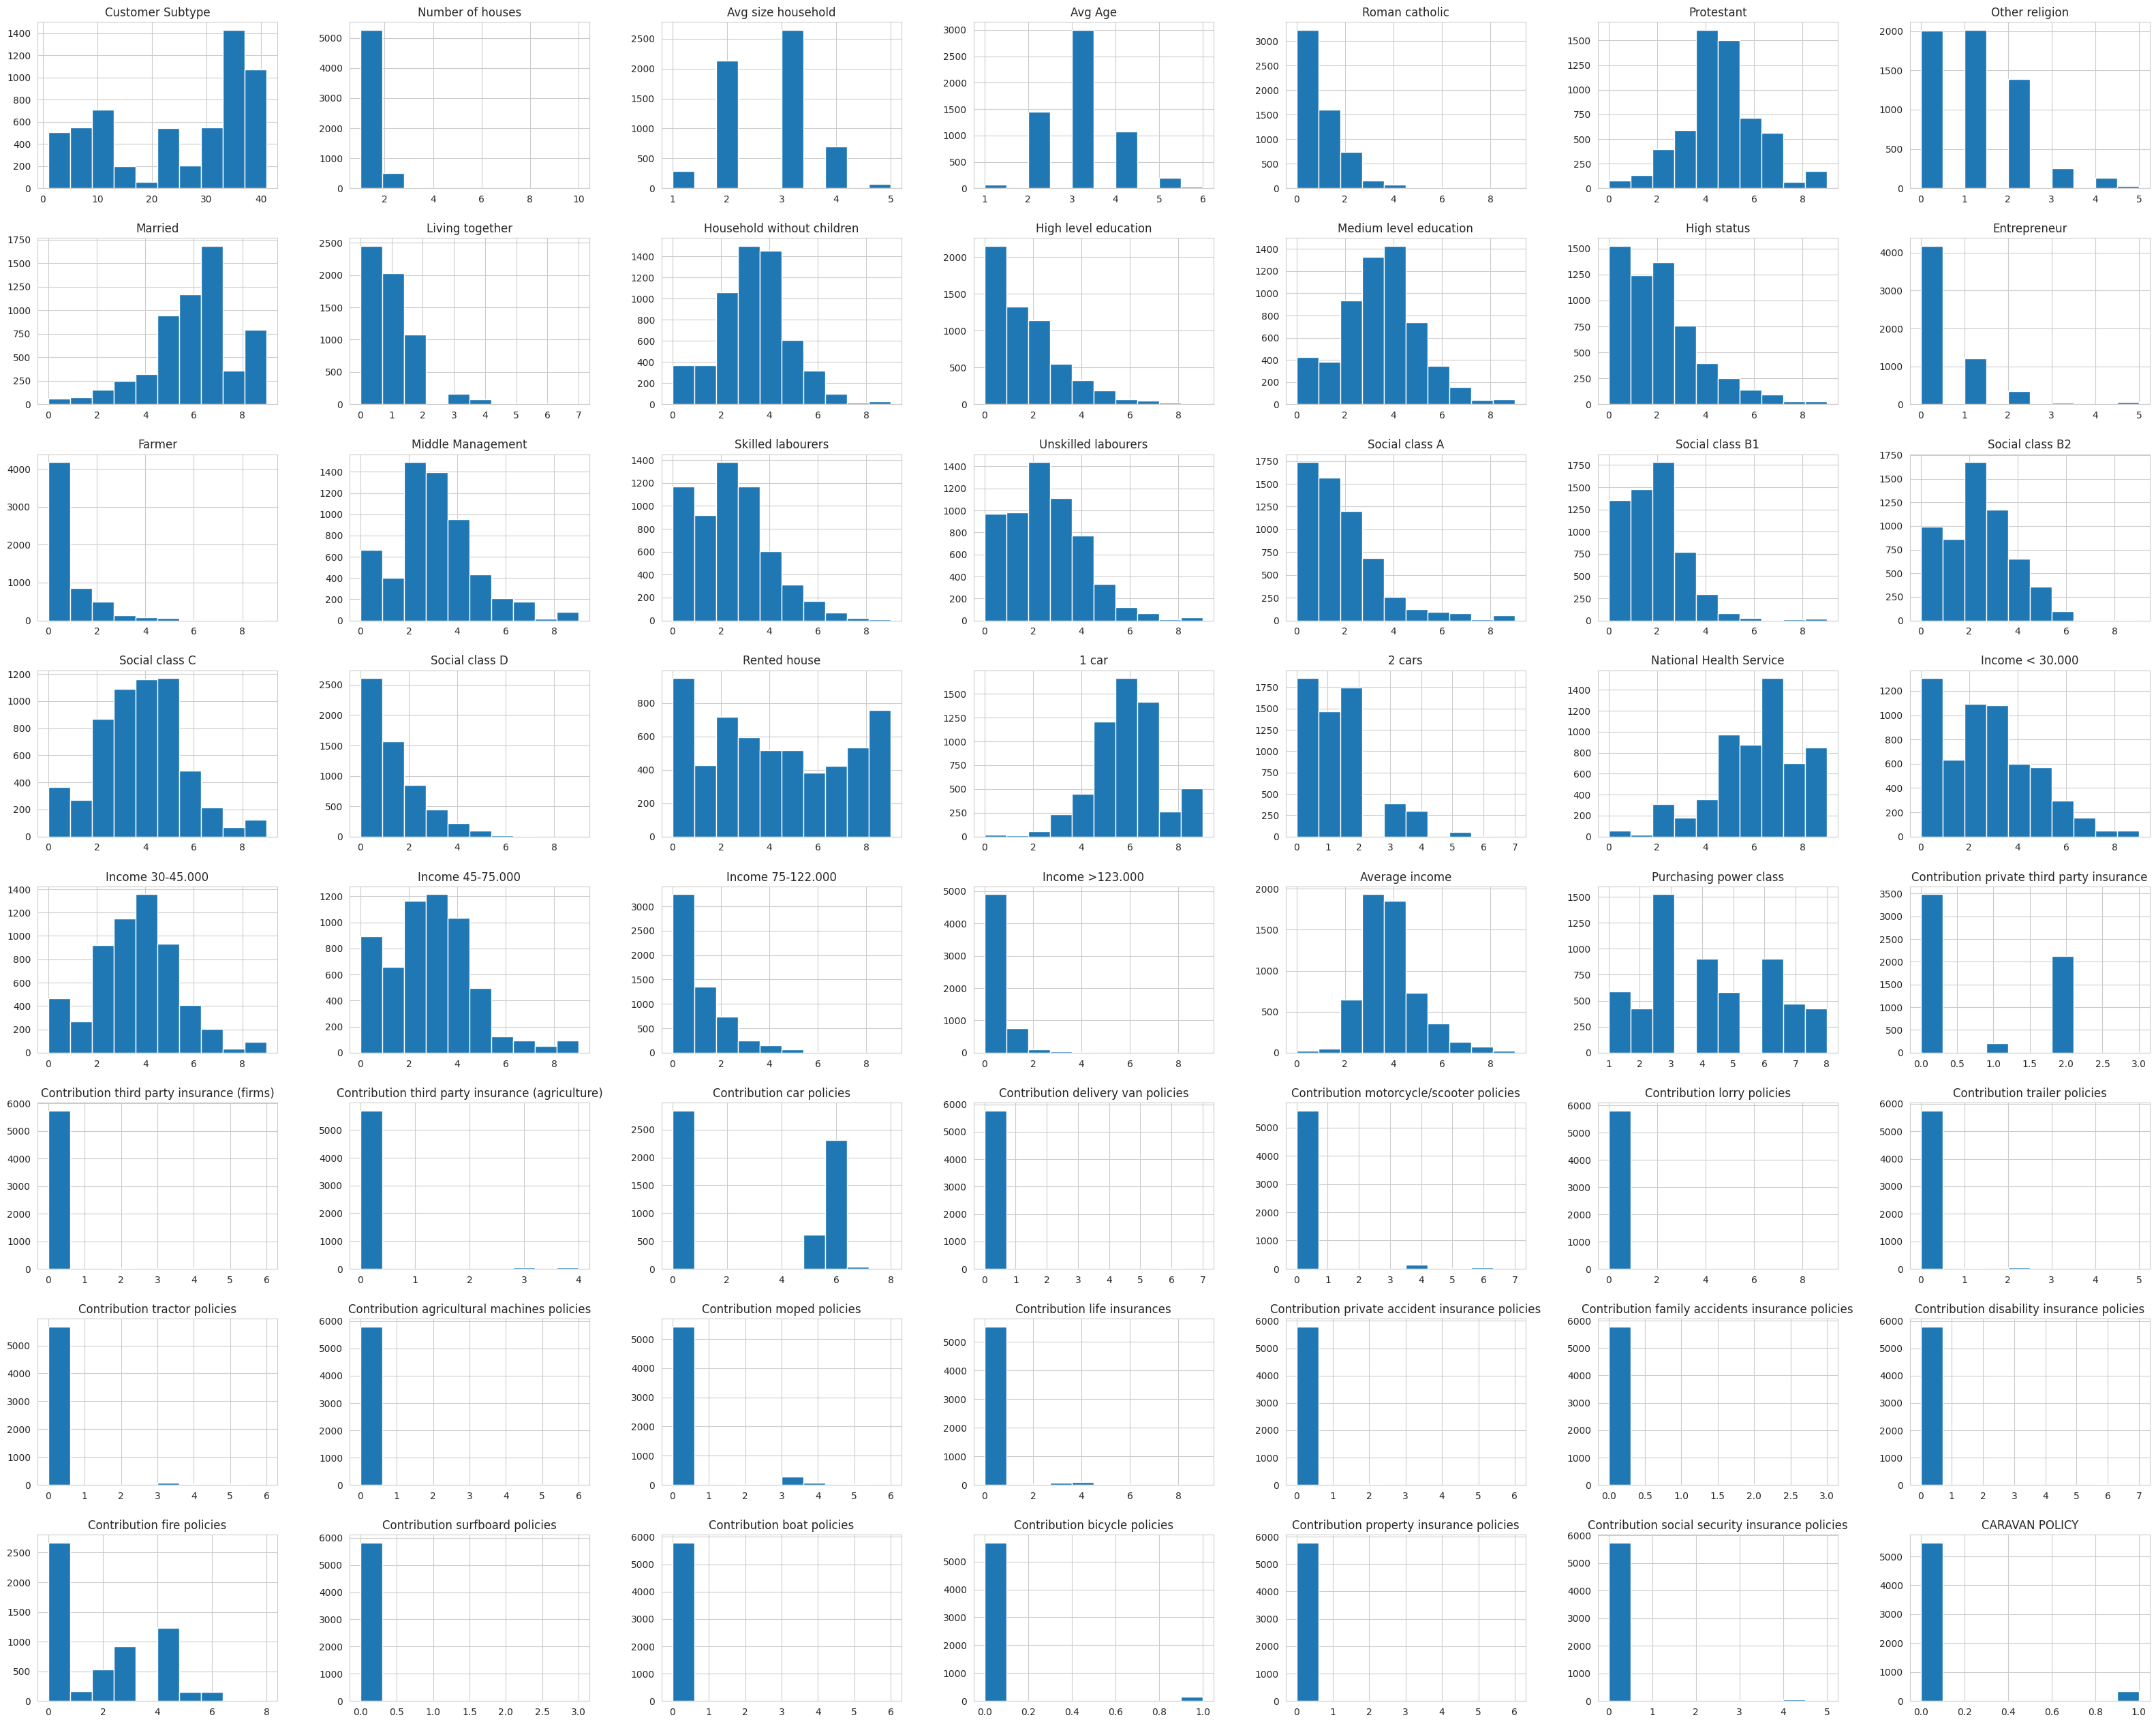

In [ ]:
# plot histogram of remaining features
data_train1.hist(figsize=(40,32))

In [ ]:
# filter out features with single class
drop_features2 = ['Contribution third party insurance (firms)', 'Contribution third party insurance (agriculture)', 'Contribution delivery van policies',
                  'Contribution motorcycle/scooter policies', 'Contribution lorry policies', 'Contribution trailer policies', 'Contribution tractor policies',
                  'Contribution agricultural machines policies', 'Contribution life insurances', 'Contribution private accident insurance policies', 'Contribution family accidents insurance policies',
                  'Contribution disability insurance policies', 'Contribution surfboard policies', 'Contribution boat policies', 'Contribution property insurance policies',
                  'Contribution social security insurance policies']

data_train2 = data_train1.drop(drop_features2, axis=1)
data_train2

Customer Subtype  Number of houses  Avg size household  Avg Age  \
0                   33                 1                   3        2   
1                   37                 1                   2        2   
2                   37                 1                   2        2   
3                    9                 1                   3        3   
4                   40                 1                   4        2   
...                ...               ...                 ...      ...   
5817                36                 1                   1        2   
5818                35                 1                   4        4   
5819                33                 1                   3        4   
5820                34                 1                   3        2   
5821                33                 1                   3        3   

      Roman catholic  Protestant  Other religion  Married  Living together  \
0                  0           5               1        7                0   
1                  1           4               1        6                2   
2                  0           4               2        3                2   
3                  2           3               2        5                2   
4                  1           4               1        7                1   
...              ...         ...             ...      ...              ...   
5817               0           6               1        1                2   
5818               1           4               1        6                0   
5819               0           6               0        5                1   
5820               0           7               0        7                2   
5821               0           6               1        7                1   

      Household without children  ...  Income 75-122.000  Income >123.000  \
0                              2  ...                  0                0   
1                              4  ...                  2                0   
2                              4  ...                  0                0   
3                              3  ...                  0                0   
4                              4  ...                  0                0   
...                          ...  ...                ...              ...   
5817                           3  ...                  0                0   
5818                           2  ...                  0                0   
5819                           3  ...                  1                0   
5820                           4  ...                  0                0   
5821                           4  ...                  1                0   

      Average income  Purchasing power class  \
0                  4                       3   
1                  5                       4   
2                  3                       4   
3                  4                       4   
4                  6                       3   
...              ...                     ...   
5817               3                       3   
5818               4                       5   
5819               3                       3   
5820               4                       6   
5821               3                       3   

      Contribution private third party insurance  Contribution car policies  \
0                                              0                          6   
1                                              2                          0   
2                                              2                          6   
3                                              0                          6   
4                                              0                          0   
...                                          ...                        ...   
5817                                           2                          6   
5818                                           0          

In [ ]:
# get cross-table of labels
pd.crosstab(data_train2['CARAVAN POLICY'], data_train2['CARAVAN POLICY']) # looks really imbalanced

CARAVAN POLICY     0    1
CARAVAN POLICY           
0               5474    0
1                  0  348

## Data-Preprocessing

In [ ]:
# split features and outcome
X_train = data_train2.iloc[:,:-1]
y_train = data_train2.iloc[:,-1:]

# use SMOTE to oversample minority class
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scaling features to achieve zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_scaled_df = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns)
print(X_scaled.shape)

(5822, 39)


In [ ]:
pd.crosstab(y_train_resampled['CARAVAN POLICY'], y_train_resampled['CARAVAN POLICY'])

CARAVAN POLICY     0     1
CARAVAN POLICY            
0               5474     0
1                  0  5474

In [ ]:
# compute chi2 scores for all variables
chi2 = SelectKBest(chi2, k=39)
X_chi2 = chi2.fit_transform(X_train_resampled, y_train_resampled)

In [ ]:
# save scores in dataframe
chi2_scores = chi2.scores_
chi2_df = pd.DataFrame(data = chi2_scores,index = X_train_resampled.columns, columns = ['Chi2'])
chi2_df = chi2_df.sort_values(by='Chi2', ascending = False)
chi2_df.head(20)

Chi2
Contribution car policies                   2575.639800
Customer Subtype                            2119.213287
Rented house                                1354.770315
Income < 30.000                             1118.130461
Farmer                                      1017.782609
Social class D                               951.243436
Contribution moped policies                  623.688591
Skilled labourers                            604.323277
Unskilled labourers                          550.846342
Contribution fire policies                   504.912486
Social class C                               384.287843
Living together                              296.708120
National Health Service                      288.080158
Purchasing power class                       253.047101
High level education                         182.716765
Contribution private third party insurance   168.284580
Other religion                               153.836991
Income >123.000                              151.244016
Roman catholic                               143.633293
High status                                  100.392066

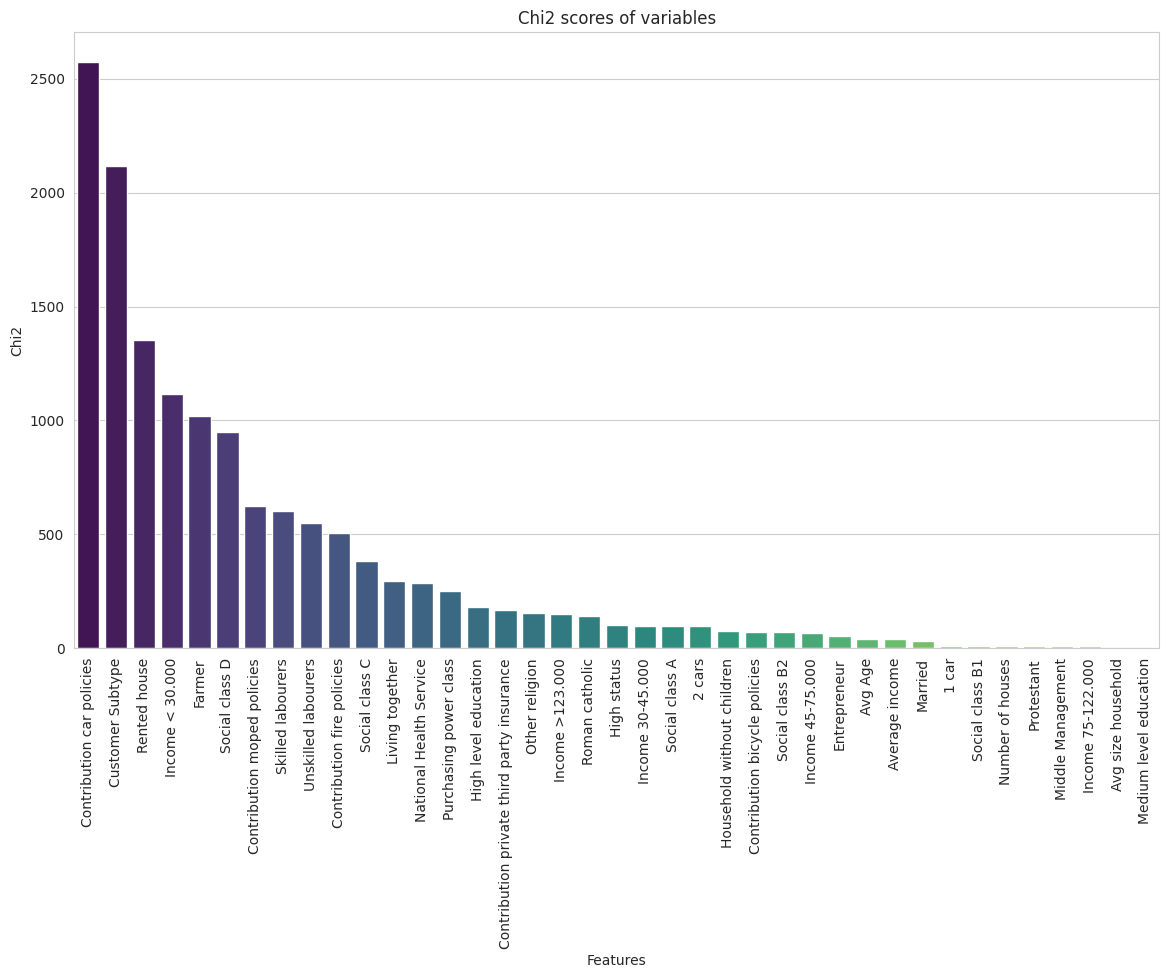

In [ ]:
# plot chi2 scores of features
plt.figure(figsize = (14, 8))
sns.set_style("whitegrid")

sns.barplot(x = chi2_df.index, y = 'Chi2', data = chi2_df, palette ='viridis')

plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Chi2')
plt.title('Chi2 scores of variables')

plt.show()

In [ ]:
# create list of best 10 features to keep
best_10_f = list(chi2_df.index[:10])
best_10_f

['Contribution car policies',
 'Customer Subtype',
 'Rented house',
 'Income < 30.000',
 'Farmer',
 'Social class D',
 'Contribution moped policies',
 'Skilled labourers',
 'Unskilled labourers',
 'Contribution fire policies']

In [ ]:
X_train_best_10 = X_train_resampled[best_10_f]
print(X_train_best_10.head())

   Contribution car policies  Customer Subtype  Rented house  Income < 30.000  \
0                          6                33             1                0   
1                          0                37             2                2   
2                          6                37             7                4   
3                          6                 9             5                1   
4                          0                40             4                0   

   Farmer  Social class D  Contribution moped policies  Skilled labourers  \
0       1               1                            0                  5   
1       0               0                            0                  0   
2       0               0                            0                  0   
3       0               0                            0                  1   
4       4               0                            0                  0   

   Unskilled labourers  Contribution fire policies

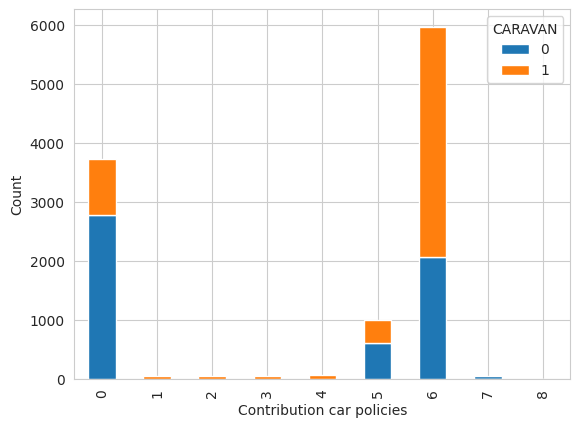

In [ ]:
# plot 4 best variables against 'CARAVAN POLICY' (Contribution car policies, Customer Subtype, Rented house, Income < 30.000)
grouped_data = X_train_resampled.groupby(['Contribution car policies', y_train_resampled['CARAVAN POLICY']]).size().unstack(fill_value=0)

# Plot the data as a stacked bar chart
grouped_data.plot(kind='bar', stacked=True)

# Set labels and legend
plt.xlabel("Contribution car policies")
plt.ylabel("Count")
plt.legend(title="CARAVAN")

# Show the plot
plt.show()

Typical customer has contribution car polcy = 0 or 5,6

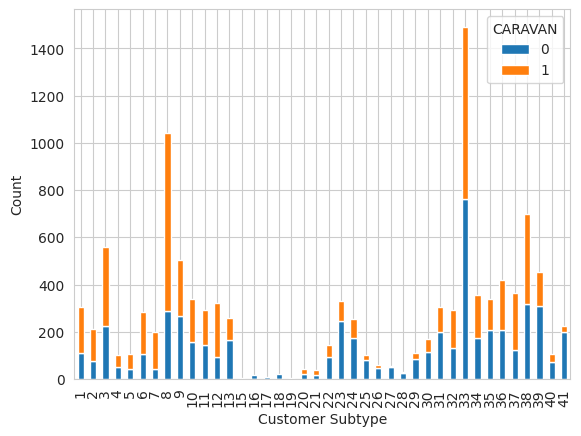

In [ ]:
grouped_data = X_train_resampled.groupby(['Customer Subtype', y_train_resampled['CARAVAN POLICY']]).size().unstack(fill_value=0)

# Plot the data as a stacked bar chart
grouped_data.plot(kind='bar', stacked=True)

# Set labels and legend
plt.xlabel("Customer Subtype")
plt.ylabel("Count")
plt.legend(title="CARAVAN")

# Show the plot
plt.show()

Typical customer has Customer Subtype = 8, 33, 38

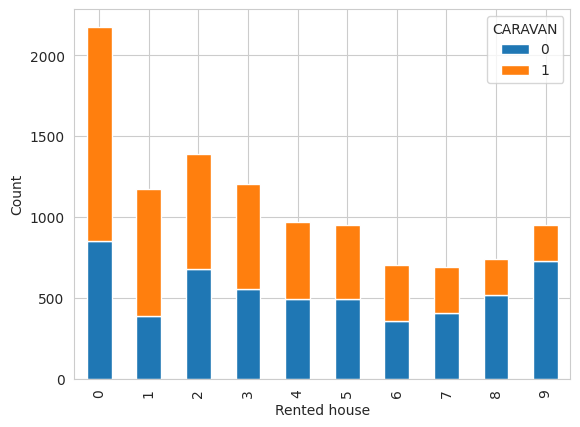

In [ ]:
grouped_data = X_train_resampled.groupby(['Rented house', y_train_resampled['CARAVAN POLICY']]).size().unstack(fill_value=0)

# Plot the data as a stacked bar chart
grouped_data.plot(kind='bar', stacked=True)

# Set labels and legend
plt.xlabel("Rented house")
plt.ylabel("Count")
plt.legend(title="CARAVAN")

# Show the plot
plt.show()

Typical customer has Rented house = 0,1,2

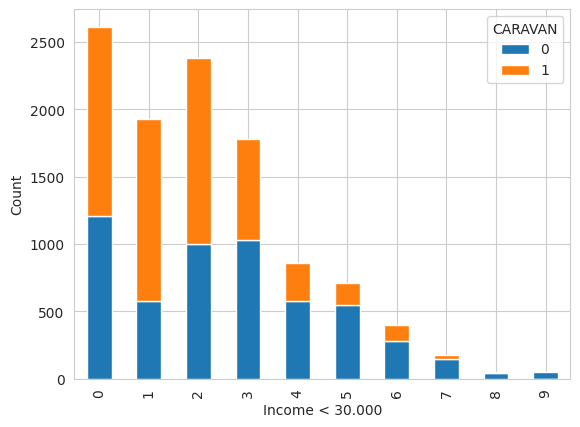

In [ ]:
grouped_data = X_train_resampled.groupby(['Income < 30.000', y_train_resampled['CARAVAN POLICY']]).size().unstack(fill_value=0)

# Plot the data as a stacked bar chart
grouped_data.plot(kind='bar', stacked=True)

# Set labels and legend
plt.xlabel("Income < 30.000")
plt.ylabel("Count")
plt.legend(title="CARAVAN")

# Show the plot
plt.show()

Typical customer has Income < 30.000 = 0,2,1

In [ ]:
# not used in the end
do_pca = False

if do_pca:
  # Principal component analysis for dimensionality reduction
  pca = PCA(svd_solver='randomized',n_components=10,random_state=42).fit(X_train_resampled)

  X_train_pca = pca.transform(X_train_resampled)
  #print(pca.components_)
  #print(pca.explained_variance_)
  #print(pca.explained_variance_ratio_)
  #print(pca.mean_)
  print(pca.n_components_)
  print(pca.noise_variance_)
  plt.figure(1, figsize=(8, 4.5))
  plt.clf()
  plt.axes([.2, .2, .7, .7])
  plt.plot(pca.explained_variance_, linewidth=2)
  plt.axis('tight')
  plt.xlabel('n_components')
  plt.ylabel('explained_variance_')
  plt.show()

  feature_names = X_train_resampled.columns
  # Get the explained variance ratio
  explained_var_ratio = pca.explained_variance_ratio_

  # Get the loadings
  loadings = pca.components_

  # Print the feature names and their loadings for each principal component
  for i, (component, evr) in enumerate(zip(loadings, explained_var_ratio)):
      print(f"Principal Component {i+1}: Explained Variance Ratio = {evr:.2f}")
      for j, (feature, loading) in enumerate(zip(feature_names, component)):
          print(f"    {feature}: {loading:.2f}")

  #print(pd.DataFrame(pca.components_,columns=X_scaled_df.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10']))

In [ ]:
from sklearn.feature_selection import chi2
best_features = []
# Decision Tree
select = SelectKBest(score_func=chi2, k=4)
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=4, class_weight='balanced', random_state=SEED)
pipeClassifierTree = make_pipeline(select, clf_tree).fit(X_train_best_10,y_train_resampled)

kbest = SelectKBest(chi2, k=4).fit(X_train_best_10,y_train_resampled).get_feature_names_out(X_train_best_10.columns)
best_features.append(kbest)

print(best_features[0])
#print(X_train_resampled.columns)

X_best = X_train_best_10[best_features[0]]
y_best = y_train_resampled

pred = pipeClassifierTree.predict(X_train_best_10)
conf_matrix = confusion_matrix(y_best, pred)
print(conf_matrix)

['Contribution car policies' 'Customer Subtype' 'Rented house'
 'Income < 30.000']
[[3750 1724]
 [1484 3990]]


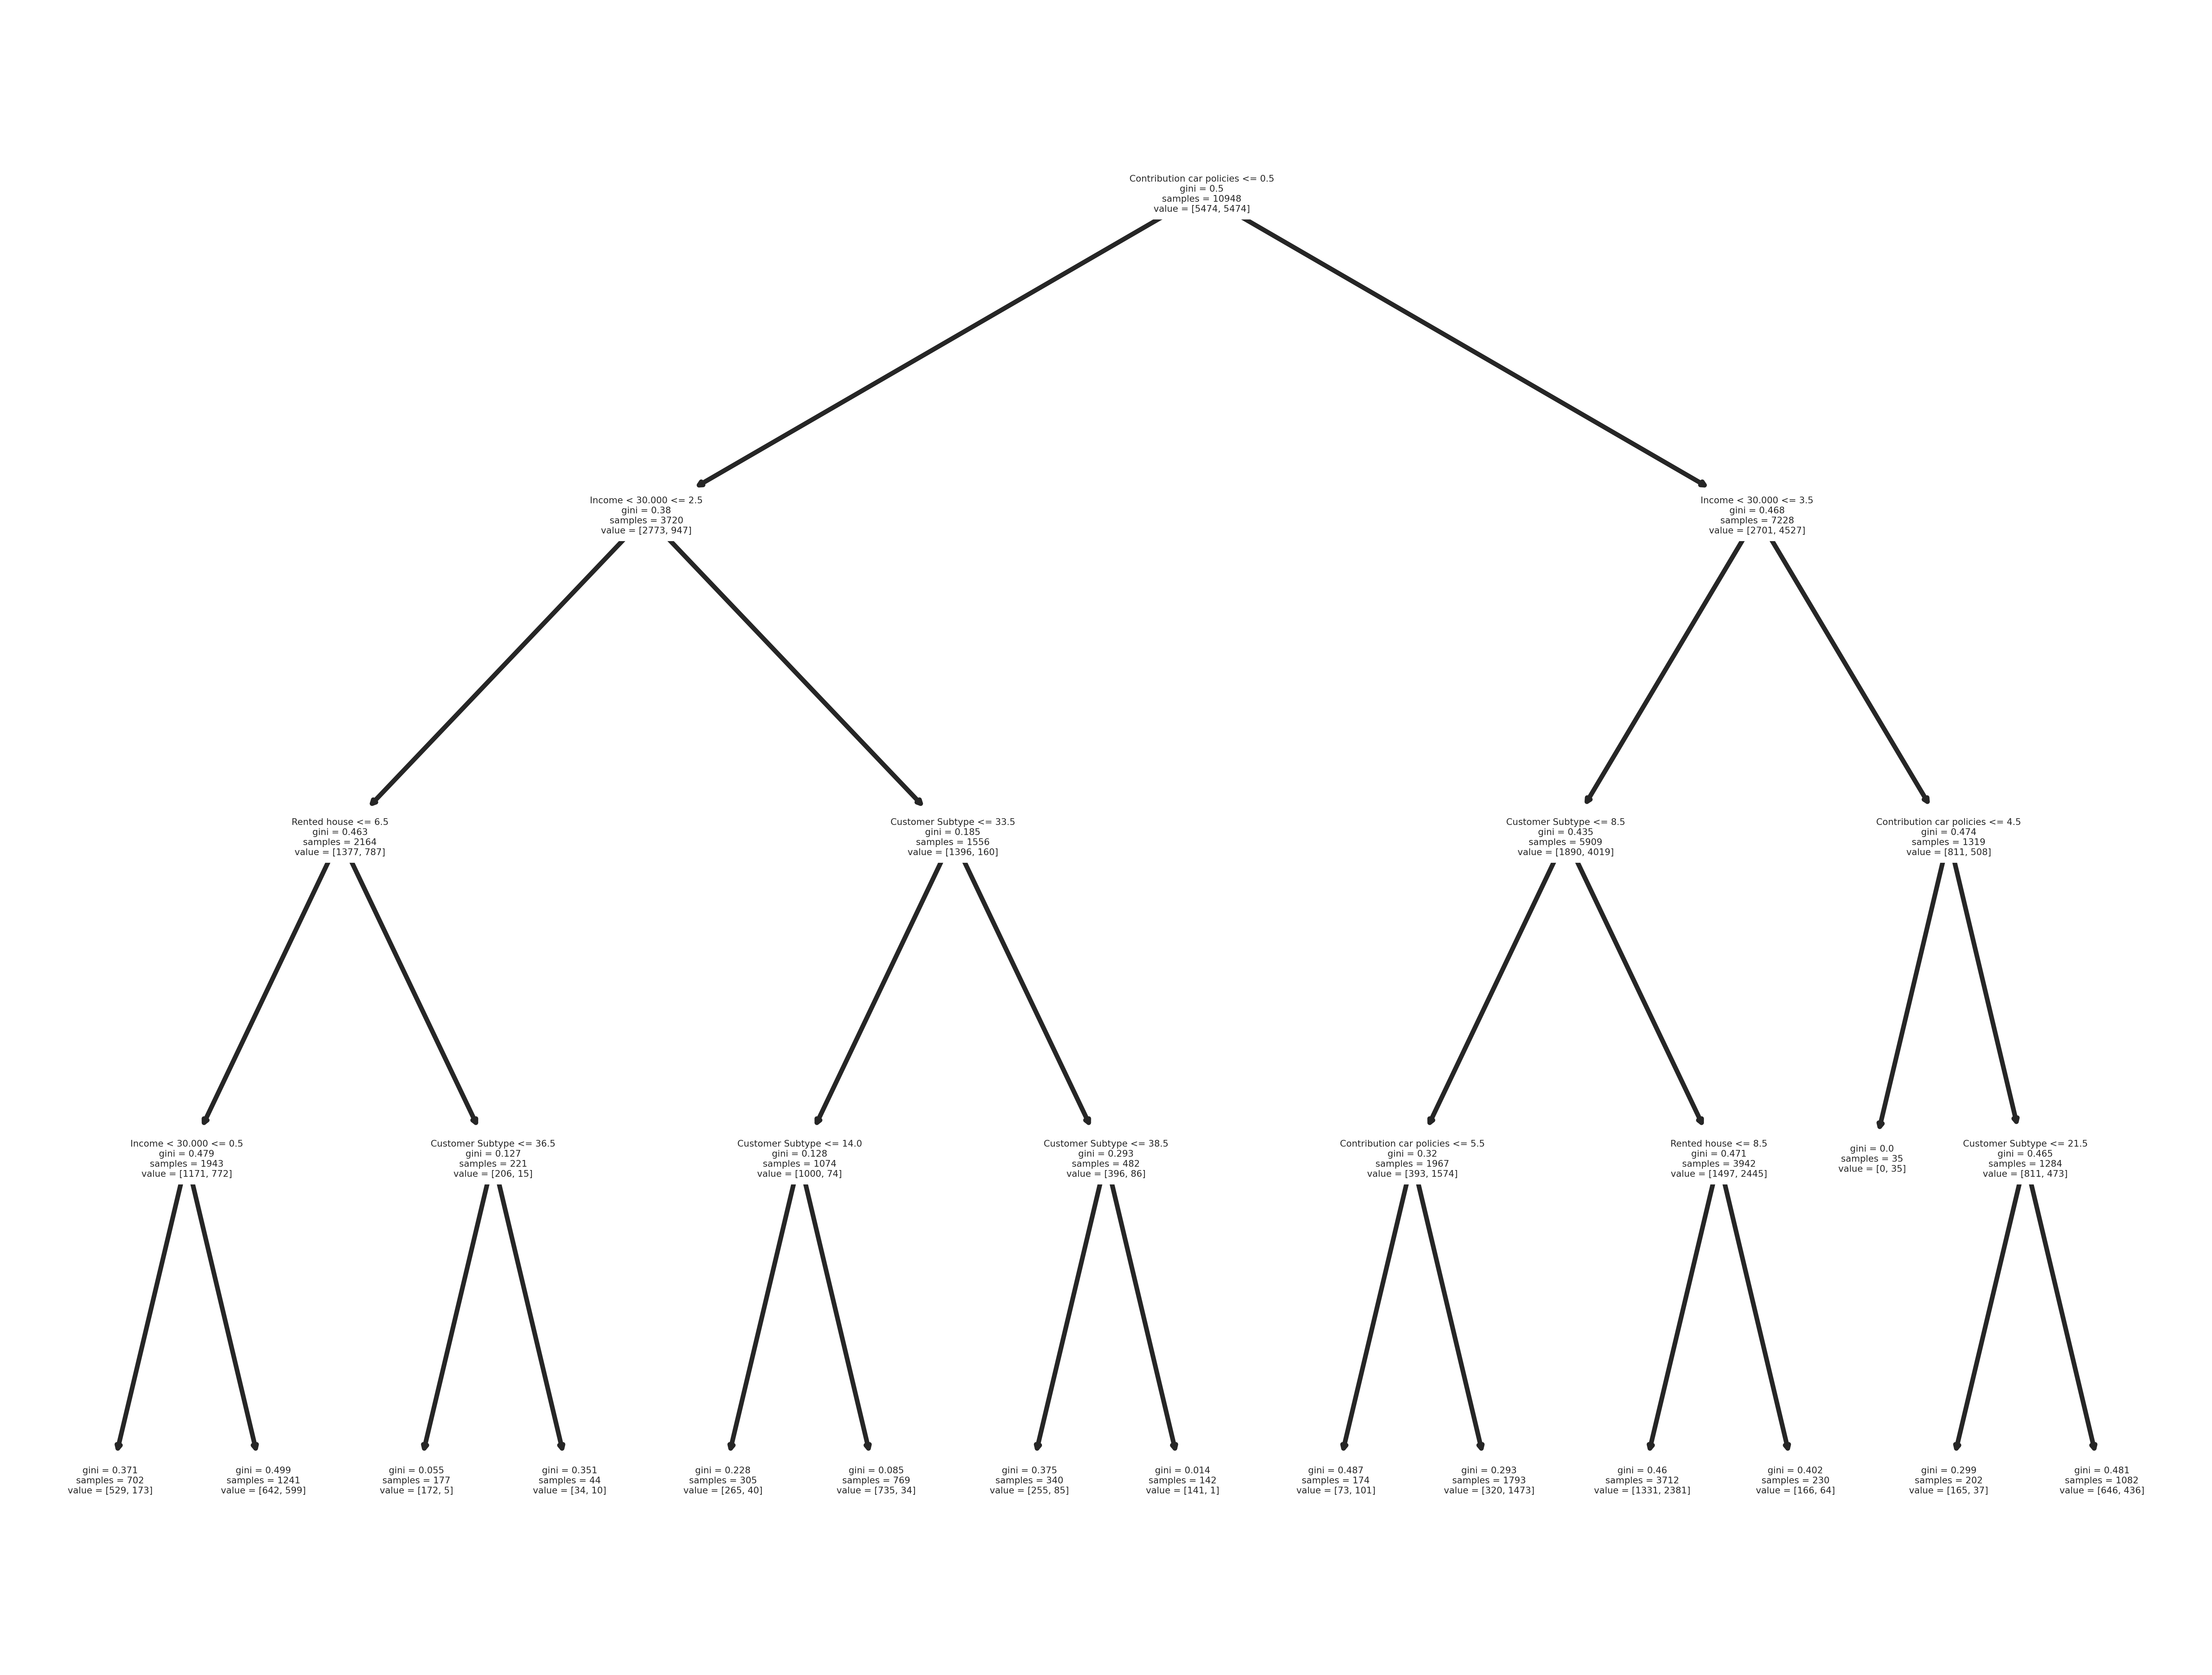

In [ ]:
# plot decision tree
fig = plt.figure()
ax = fig.add_axes((0,0,1,1))
fig.set_dpi(1000)
plot_tree(clf_tree, ax=ax, feature_names=best_features[0])
plt.show()

In [ ]:
# get text representation
tree_text = export_text(clf_tree, feature_names=list(X_best.columns))
print(tree_text)

|--- Contribution car policies <= 0.50
|   |--- Income < 30.000 <= 2.50
|   |   |--- Rented house <= 6.50
|   |   |   |--- Income < 30.000 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Income < 30.000 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Rented house >  6.50
|   |   |   |--- Customer Subtype <= 36.50
|   |   |   |   |--- class: 0
|   |   |   |--- Customer Subtype >  36.50
|   |   |   |   |--- class: 0
|   |--- Income < 30.000 >  2.50
|   |   |--- Customer Subtype <= 33.50
|   |   |   |--- Customer Subtype <= 14.00
|   |   |   |   |--- class: 0
|   |   |   |--- Customer Subtype >  14.00
|   |   |   |   |--- class: 0
|   |   |--- Customer Subtype >  33.50
|   |   |   |--- Customer Subtype <= 38.50
|   |   |   |   |--- class: 0
|   |   |   |--- Customer Subtype >  38.50
|   |   |   |   |--- class: 0
|--- Contribution car policies >  0.50
|   |--- Income < 30.000 <= 3.50
|   |   |--- Customer Subtype <= 8.50
|   |   |   |--- Contribution car policies <= 5.50
|   |   

In [ ]:
# get importance of features
important_feat = clf_tree.feature_importances_
sorted_features = np.argsort(important_feat)
feature_names = X_train.columns.tolist()

for i in sorted_features:
  print(f'{feature_names[i]}: {important_feat[i]}')

Avg size household: 0.07632485290213334
Number of houses: 0.09699189025098329
Avg Age: 0.274901601211982
Customer Subtype: 0.5517816556349013


In [ ]:
# Second decision tree
clf_tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=4, class_weight='balanced', random_state=SEED)
clf_tree2 = clf_tree2.fit(X_train_resampled, y_train_resampled)

clf_tree2_text = export_text(clf_tree2, feature_names=list(X_train_resampled.columns))
print(tree_text)

|--- Contribution car policies <= 0.50
|   |--- Income < 30.000 <= 2.50
|   |   |--- Rented house <= 6.50
|   |   |   |--- Income < 30.000 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Income < 30.000 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Rented house >  6.50
|   |   |   |--- Customer Subtype <= 36.50
|   |   |   |   |--- class: 0
|   |   |   |--- Customer Subtype >  36.50
|   |   |   |   |--- class: 0
|   |--- Income < 30.000 >  2.50
|   |   |--- Customer Subtype <= 33.50
|   |   |   |--- Customer Subtype <= 14.00
|   |   |   |   |--- class: 0
|   |   |   |--- Customer Subtype >  14.00
|   |   |   |   |--- class: 0
|   |   |--- Customer Subtype >  33.50
|   |   |   |--- Customer Subtype <= 38.50
|   |   |   |   |--- class: 0
|   |   |   |--- Customer Subtype >  38.50
|   |   |   |   |--- class: 0
|--- Contribution car policies >  0.50
|   |--- Income < 30.000 <= 3.50
|   |   |--- Customer Subtype <= 8.50
|   |   |   |--- Contribution car policies <= 5.50
|   |   

In [ ]:
# get importance of features
important_feat = clf_tree2.feature_importances_
sorted_features = np.argsort(important_feat)
feature_names = X_train.columns.tolist()

for i in sorted_features:
  print(f'{feature_names[i]}: {important_feat[i]}')

Customer Subtype: 0.0
Purchasing power class: 0.0
Average income: 0.0
Income >123.000: 0.0
Income 75-122.000: 0.0
Income 45-75.000: 0.0
Income 30-45.000: 0.0
National Health Service: 0.0
1 car: 0.0
Rented house: 0.0
Social class C: 0.0
Social class A: 0.0
Unskilled labourers: 0.0
Skilled labourers: 0.0
Social class B1: 0.0
Married: 0.0
Number of houses: 0.0
Avg size household: 0.0
Avg Age: 0.0
Roman catholic: 0.0
Other religion: 0.0
Farmer: 0.0
Living together: 0.0
Contribution bicycle policies: 0.0
High level education: 0.0
Medium level education: 0.0
High status: 0.0
Entrepreneur: 0.0
Household without children: 0.0
Protestant: 0.003153215015399044
Middle Management: 0.004936500551493416
Social class B2: 0.01448474036989293
Contribution private third party insurance: 0.025978831080542747
Contribution moped policies: 0.04925049830952828
Social class D: 0.06695844106646764
2 cars: 0.07274335147849864
Income < 30.000: 0.1382182439651294
Contribution fire policies: 0.1834678138984486
Con

['Customer Subtype' 'Rented house' 'Income < 30.000'
 'Contribution car policies']


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: ylabel='Feature'>

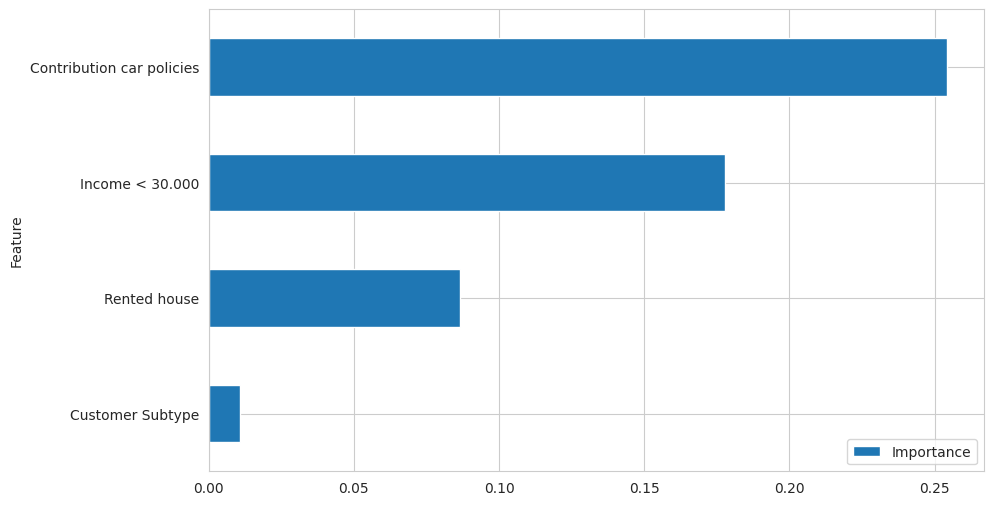

In [ ]:
classifier = LogisticRegression(class_weight='balanced', random_state=SEED)
pipeClassifier = make_pipeline(SelectKBest(chi2, k=4), classifier)
#k is the number of variables selected
pipeClassifier.fit(X_train_resampled, y_train_resampled)
best_f = pipeClassifier[:-1].get_feature_names_out()
print(best_f)

# get importance of features
coefs = classifier.coef_

avg_importance = np.mean(np.abs(coefs), axis=0)
feature_imp = pd.DataFrame({'Feature': best_f, 'Importance': avg_importance})
feature_imp = feature_imp.sort_values('Importance', ascending=True)
feature_imp.plot(x='Feature', y='Importance', kind='barh', figsize=(10,6))

/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


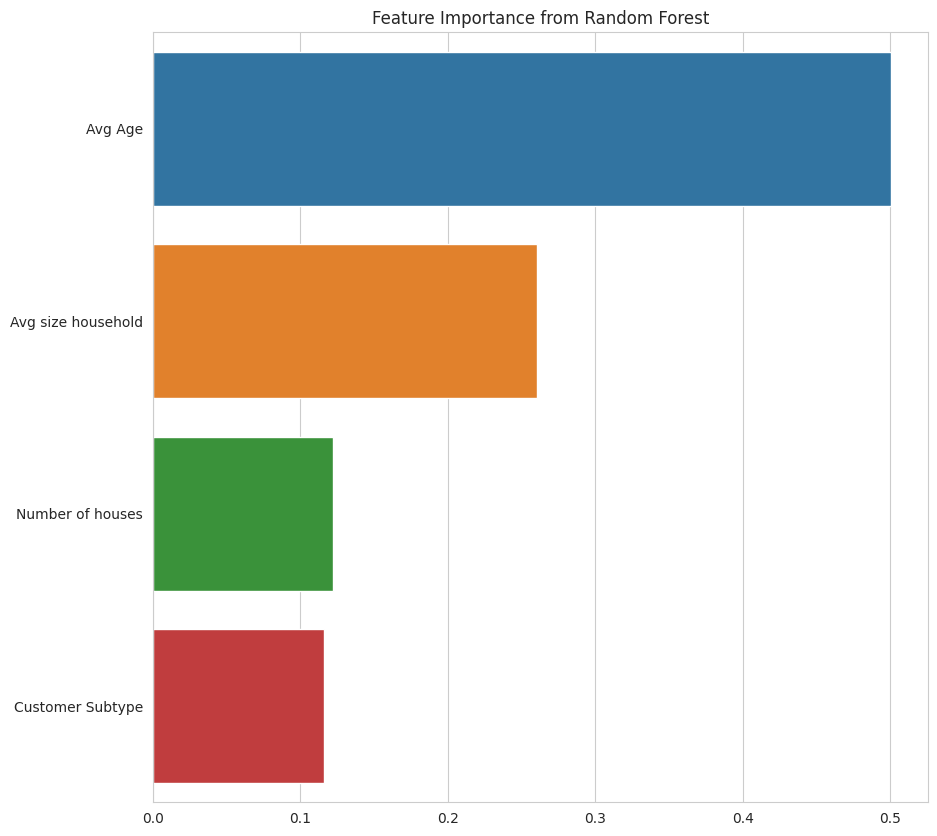

In [ ]:
# Random forest
clf_rf = RandomForestClassifier(max_depth=4, criterion='gini', random_state=SEED)
pipeClassifier_rf = make_pipeline(SelectKBest(chi2, k=4), clf_rf)
pipeClassifier_rf.fit(X_train_resampled, y_train_resampled)

# Get feature importances
importances = clf_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx])
plt.title("Feature Importance from Random Forest")
plt.show()

## 2.2 Predict potential customers

Classification report for model  Decision Tree
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1679
           1       0.68      0.77      0.72      1606

    accuracy                           0.71      3285
   macro avg       0.72      0.71      0.71      3285
weighted avg       0.72      0.71      0.71      3285



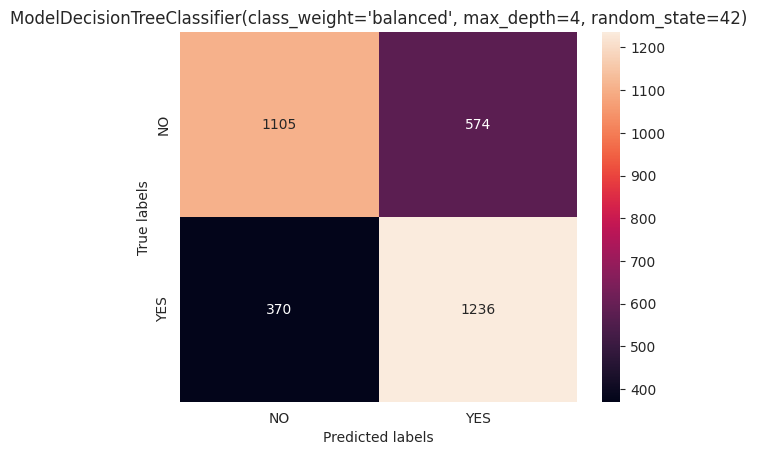

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report for model  LogReg
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1679
           1       0.68      0.73      0.70      1606

    accuracy                           0.70      3285
   macro avg       0.70      0.70      0.70      3285
weighted avg       0.70      0.70      0.70      3285



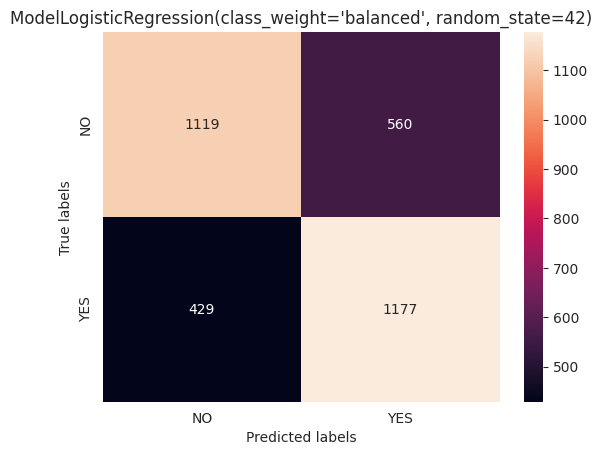

<ipython-input-147-ace568770fae>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


Classification report for model  Random Forest
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1679
           1       0.71      0.78      0.75      1606

    accuracy                           0.74      3285
   macro avg       0.74      0.74      0.74      3285
weighted avg       0.74      0.74      0.74      3285



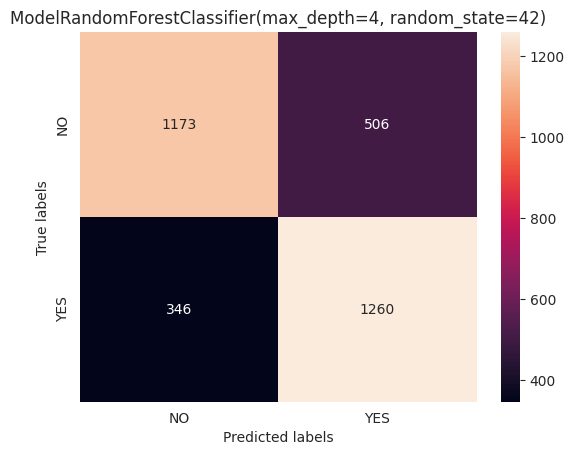

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report for model  Naive Bayes
              precision    recall  f1-score   support

           0       0.77      0.54      0.64      1679
           1       0.64      0.83      0.72      1606

    accuracy                           0.68      3285
   macro avg       0.70      0.69      0.68      3285
weighted avg       0.70      0.68      0.68      3285



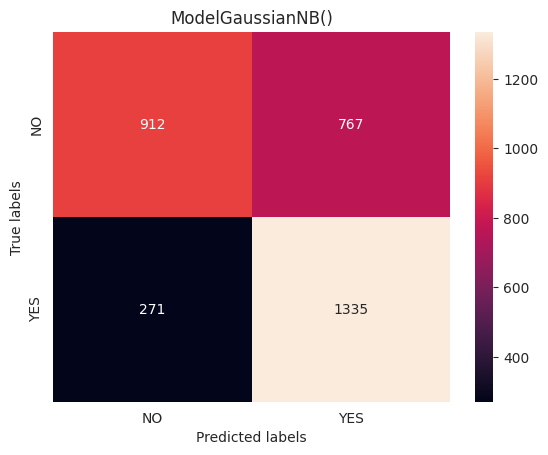

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report for model  SVM
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      1679
           1       0.69      0.76      0.73      1606

    accuracy                           0.72      3285
   macro avg       0.72      0.72      0.72      3285
weighted avg       0.72      0.72      0.72      3285



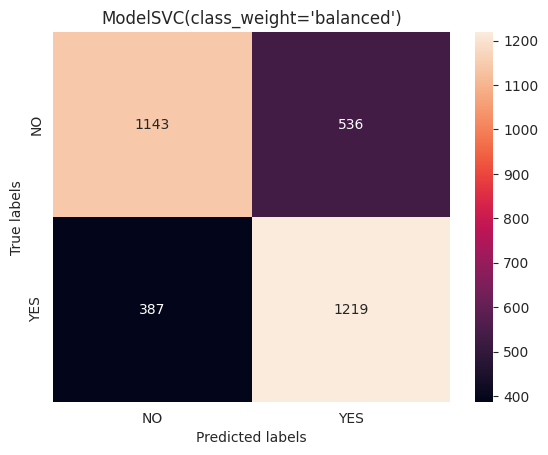

In [ ]:
# train models on most important features
classifiers = [DecisionTreeClassifier(criterion='gini', class_weight='balanced', max_depth=4,random_state=42),
              LogisticRegression(class_weight='balanced', random_state=SEED),
              RandomForestClassifier(max_depth=4, criterion='gini', random_state=SEED),
              GaussianNB(),
              SVC(class_weight = 'balanced')
              ]

c_names = ['Decision Tree', "LogReg", "Random Forest", "Naive Bayes", "SVM"]
fitted_classifiers = []

# train each model and plot their scores
for c, classifier in enumerate(classifiers):

    X_train,X_test,y_train,y_test = train_test_split(X_train_best_10,y_train_resampled,train_size=0.7,random_state=42)

    classifier.fit(X_train, y_train)
    fitted_classifiers.append(classifier)
    y_pred_train = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)

    print("Classification report for model ", c_names[c])
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test,y_pred)


    plt.figure()
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels');
    ax.set_title('Model{}'.format(classifier));
    ax.xaxis.set_ticklabels(['NO', 'YES']); ax.yaxis.set_ticklabels(['NO', 'YES']);

    plt.show()



According to macro/weighted avg choose RandomForest Classifier

In [ ]:
best = fitted_classifiers[2]
best

RandomForestClassifier(max_depth=4, random_state=42)

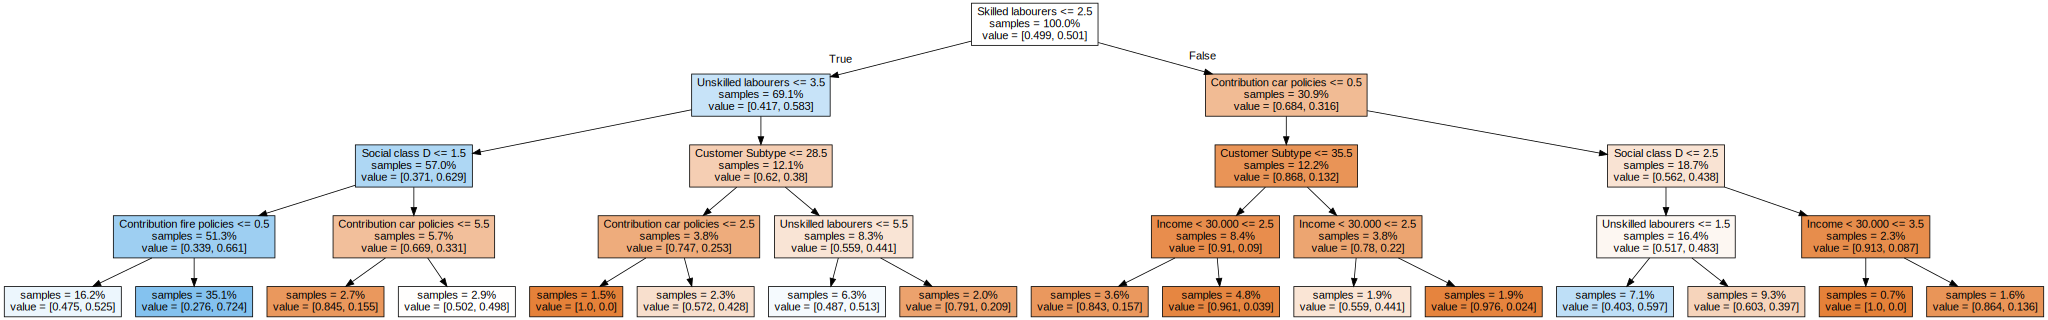

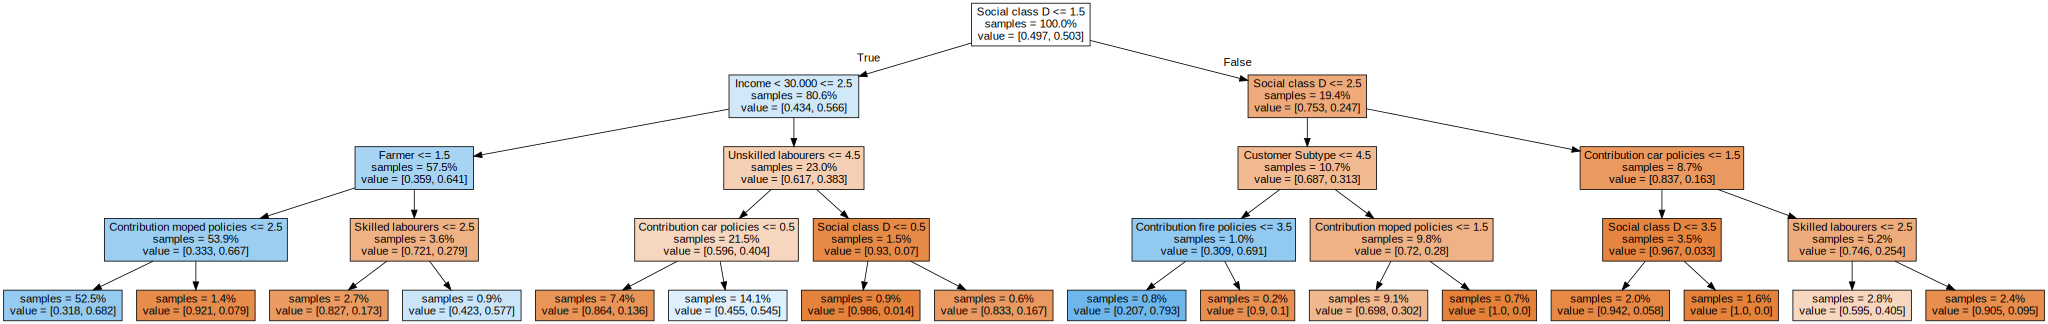

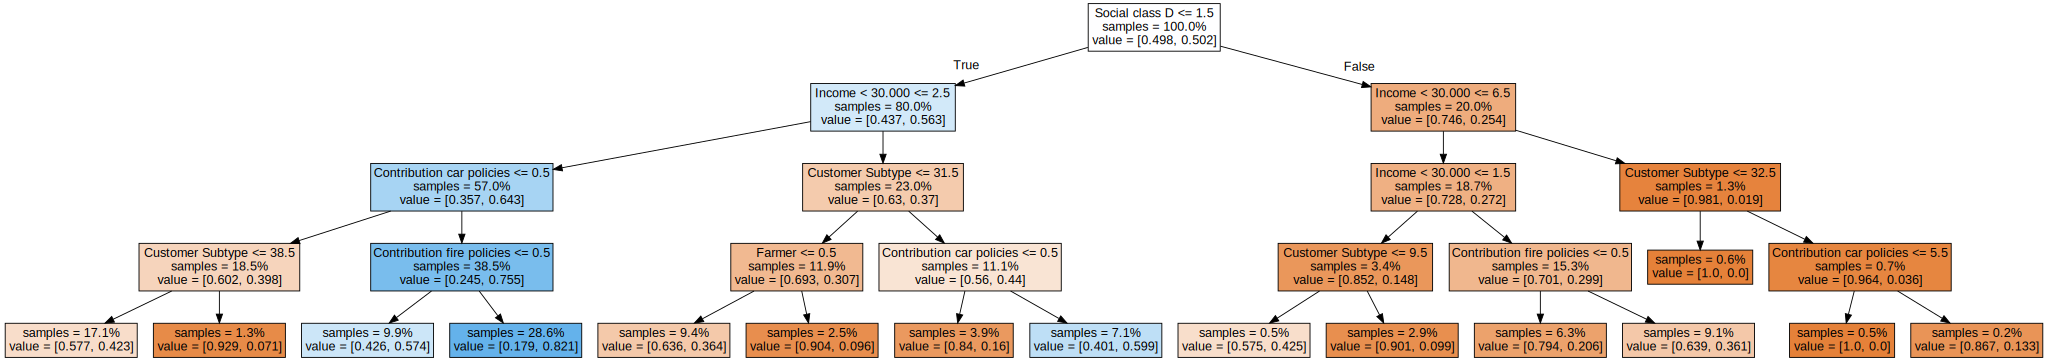

In [ ]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = best.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_best_10.columns,
                               filled=True,
                               max_depth=4,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
# create test data
data_test = pd.read_csv(test_data_path)

X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1:]

Summary of the 800 most likely policy owners and the models certainty:

0.769821    42
0.626019    19
0.766978    14
0.757116    11
0.754090    10
            ..
0.658734     1
0.661073     1
0.661936     1
0.665484     1
0.572782     1
Length: 461, dtype: int64 

Indices of the selected 800:
 [3783, 3772, 2667, 947, 2132, 2310, 3281, 38, 443, 2798, 2118, 2112, 340, 2678, 56, 1969, 2274, 3083, 2510, 3303, 3871, 2587, 3862, 706, 209, 2135, 1383, 1856, 2843, 3986, 2164, 1689, 3704, 364, 1268, 140, 2416, 1242, 1690, 165, 970, 285, 2929, 1096, 1712, 1384, 3894, 3347, 2634, 1634, 3007, 2515, 3800, 3603, 1896, 3092, 3726, 1670, 2122, 1, 3293, 454, 352, 2152, 814, 640, 229, 3910, 1641, 313, 2016, 903, 2216, 595, 2385, 1879, 3831, 3012, 1819, 3455, 1929, 1664, 2356, 1562, 1271, 2240, 2379, 2981, 3983, 2388, 2560, 3068, 990, 786, 3266, 2434, 2865, 917, 1028, 1705, 2091, 1252, 2390, 3913, 1253, 113, 305, 2737, 3943, 2911, 3836, 2802, 2239, 3716, 2621, 774, 1159, 3604, 2985, 1938, 2893, 3426, 219

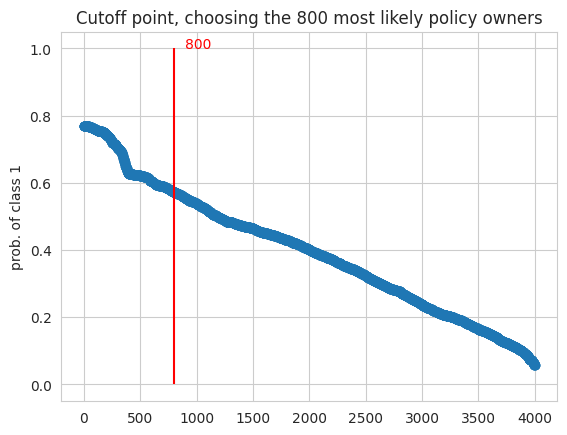

In [ ]:
# predict the probabilities for being a policy holder in the test set
y_pred_test = best.predict_proba(X_test[X_train_best_10.columns])[:, 1]
y_pred_test = pd.Series(y_pred_test)
#print(y_pred_test)
y_pred_test.sort_values(ascending=False, inplace=True)

#plot prediction probabilities
plt.scatter(range(len(y_pred_test)), y_pred_test)
plt.vlines(800, 0, 1, color='red')
plt.text(900, 1, '800', color='red')
plt.ylabel('prob. of class 1')
plt.title('Cutoff point, choosing the 800 most likely policy owners')
plt.plot()
most_likely_policy_owners = y_pred_test.iloc[:801].index.to_list()

print('Summary of the 800 most likely policy owners and the models certainty:\n')
print(y_pred_test.iloc[:801].value_counts(), '\n')
print('Indices of the selected 800:\n', most_likely_policy_owners)
np.savetxt('most_likely_policy_owners.csv', most_likely_policy_owners, fmt='%.0i')

In [ ]:
# check with true labels
print(np.sum(y_test))

y_test.iloc[most_likely_policy_owners].value_counts()

CARAVAN POLICY    238
dtype: int64


CARAVAN POLICY
0                 694
1                 107
dtype: int64